In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load Libraries

In [4]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ImportError: cannot import name 'DeferredError' from 'PIL._util' (/Users/vitthal/miniforge3/lib/python3.10/site-packages/PIL/_util.py)

# Load Data

In [4]:
df_all = pd.read_csv("/kaggle/input/electricity-load-forecasting/continuous dataset.csv", parse_dates = ['datetime'], index_col = ['datetime'])
#df_test = pd.read_csv("/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx")
print("There are %0.0f" %df_all.shape[0] + " repeated measures and %0.0f" %df_all.shape[1] +" variables in the dataset" )
#print("There are %0.0f" %df_test.shape[0] + " houses and %0.0f" %df_test.shape[1] +" explanatory variables in the test dataset" )
#df_all = df_train.append(df_test)
#df_all.reset_index(inplace=True, drop=True) 
df_all.head()

There are 48048 repeated measures and 16 variables in the dataset


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


# Prepare Data

In [5]:
df = df_all['nat_demand'].resample('W').sum()  
df = df[1:273]            #Removing pandemic effects
df

datetime
2015-01-11    181919.6224
2015-01-18    188082.3152
2015-01-25    179448.7184
2015-02-01    184393.4256
2015-02-08    187290.1846
                 ...     
2020-02-23    216005.1882
2020-03-01    204924.9816
2020-03-08    219065.4724
2020-03-15    216436.7037
2020-03-22    200434.6963
Freq: W-SUN, Name: nat_demand, Length: 272, dtype: float64

## Train and Test data split

<AxesSubplot:xlabel='datetime'>

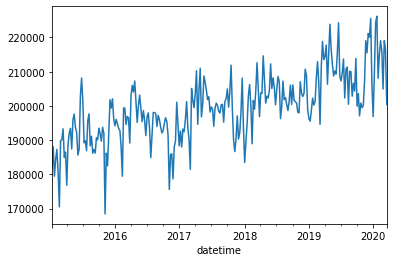

In [6]:
df.plot()

In [7]:
df_train = df[1:219]
df_test = df[219:273]      # perdicting from 2019/3/24 to 2020/3/22

## Checking for staionarity

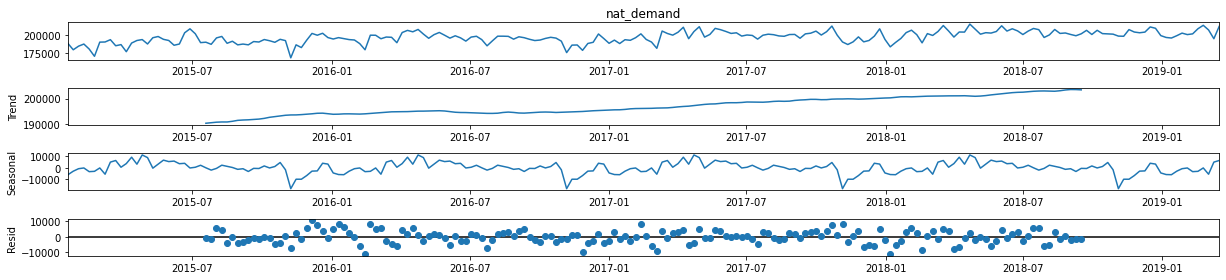

In [8]:
decomp = sm.tsa.seasonal_decompose(df_train,model = 'additive')
fig = decomp.plot()
fig.set_figwidth(20)

In [9]:
adf = adfuller(df_train)
print('adfuller test P-Value: ', adf[1])

adfuller test P-Value:  0.020741302189223345


**P-Value is less than 0.05, therefore we reject the null therefore the series is staionary**

# ARIMA 

## Manual Hyperparameters Tunning

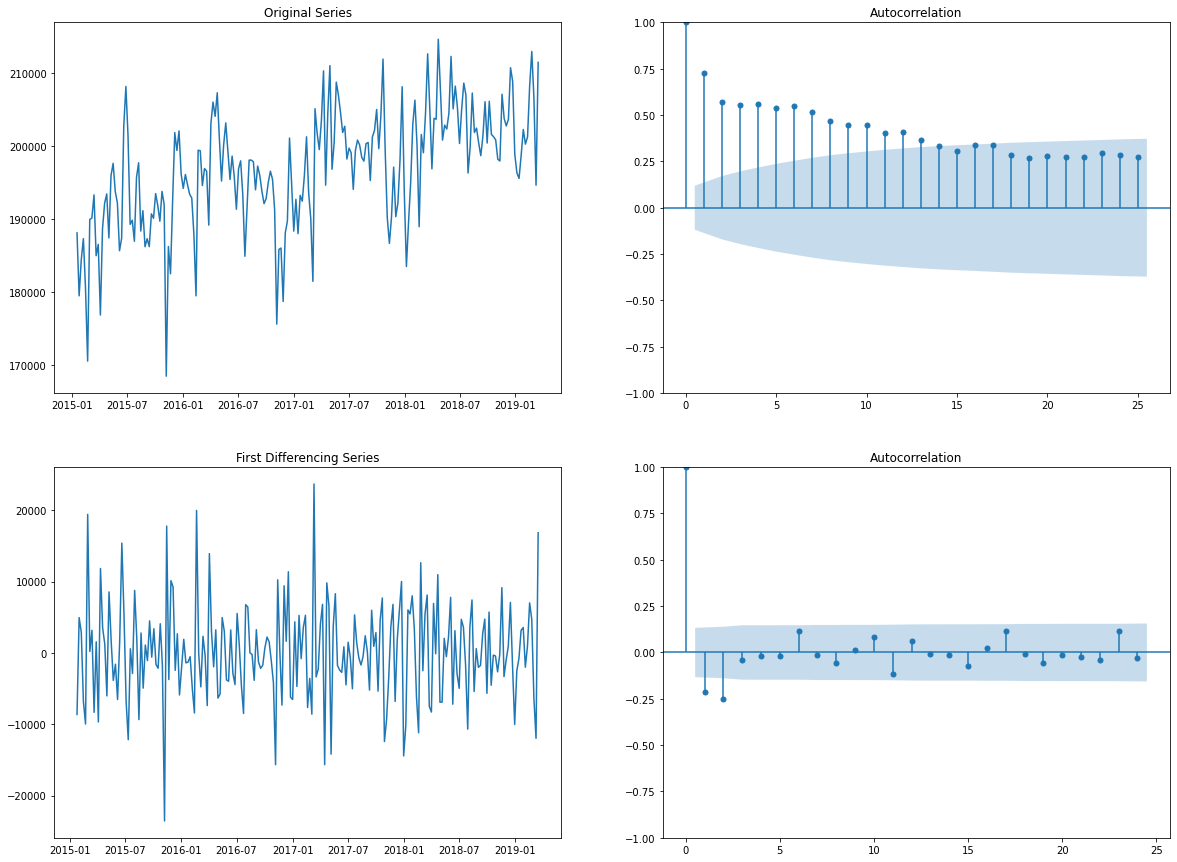

In [10]:
fig, axes = plt.subplots(2, 2, figsize = (20,15))
axes[0,0].plot(df_train)
axes[0,0].set_title('Original Series')
plot_acf(df, ax=axes[0,1])
axes[1,0].plot(df_train.diff())
axes[1,0].set_title('First Differencing Series')
plot_acf(df_train.diff().dropna(), ax=axes[1,1])
plt.show()

**This result aggrees with ADF test, so I'm going to set order of differencing (d) to be 0**

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


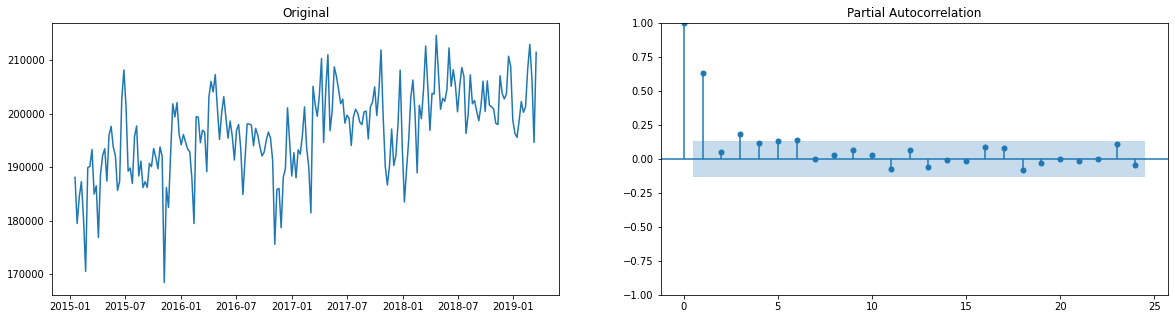

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
axes[0].plot(df_train); axes[0].set_title('Original')
#axes[1].set(ylim=(0,5))
plot_pacf(df_train, ax=axes[1])

plt.show()

**PACF lag 1 is slightly above significance limit, I will choose AR term (p) to be 1**

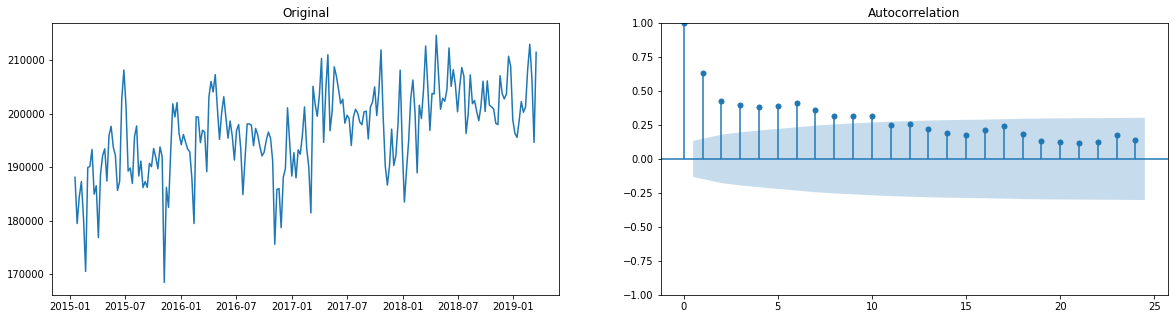

In [12]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
axes[0].plot(df_train); axes[0].set_title('Original')
plot_acf(df_train, ax=axes[1])

plt.show()

**From ACF lag, we would choose the number of terms that siginicantly above significance limit to keep a simpler model,
So in this came, I will choose MA term (q) to be 2**

## Train Model

In [13]:
model = ARIMA(df_train,exog = None, order = (1,0,2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             nat_demand   No. Observations:                  218
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2200.850
Date:                Sun, 23 Apr 2023   AIC                           4411.700
Time:                        08:08:12   BIC                           4428.622
Sample:                    01-18-2015   HQIC                          4418.535
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.968e+05   3712.062     53.026      0.000     1.9e+05    2.04e+05
ar.L1          0.9756      0.022     44.091      0.000       0.932       1.019
ma.L1         -0.4420      0.067     -6.631      0.000      -0.573      -0.311
ma.L2         -0.3202      0.069     -4.641      0.000      -0.455      -0.185
sigma2      3.315e+07      0.053   6.29e+08      0.000    3.32e+07    3.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.37
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.21
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.13e+25. Standard errors may be unstable.
"""

## Model Evaluation

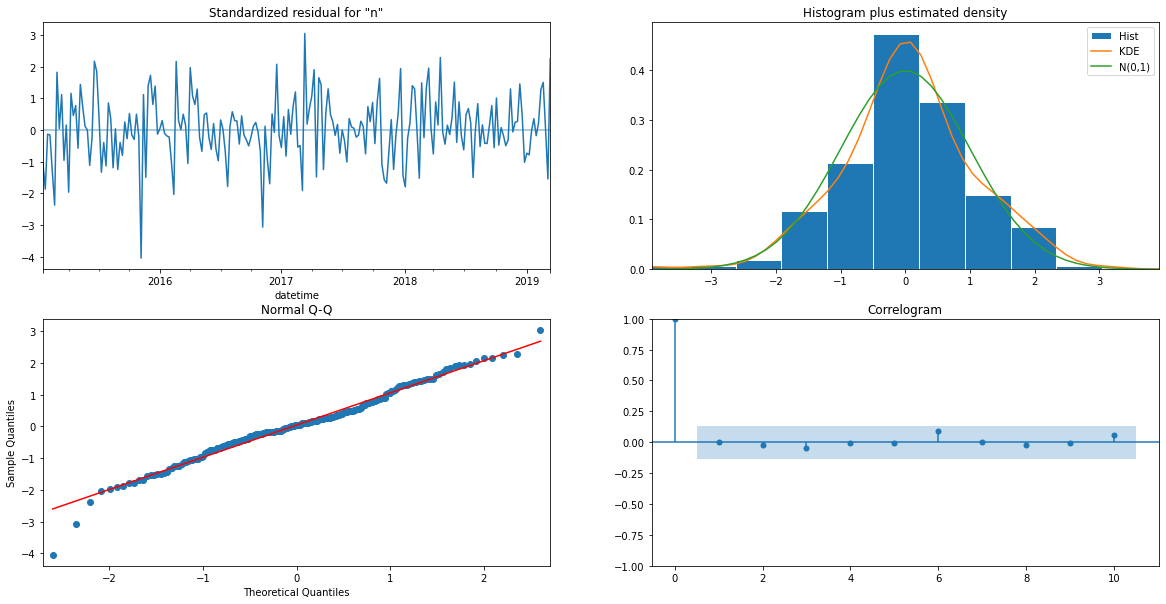

In [14]:
model.plot_diagnostics(figsize=(20,10))
plt.show()

## Predict test dataset

In [15]:
pred = model.predict(start = len(df_train),end = len(df)-2) # start and end index 
print("The Root Mean Squared Error is: "+ str(np.sqrt(mean_squared_error(df_test,pred)))) 

The Root Mean Squared Error is: 12745.584882387127


<AxesSubplot:xlabel='datetime'>

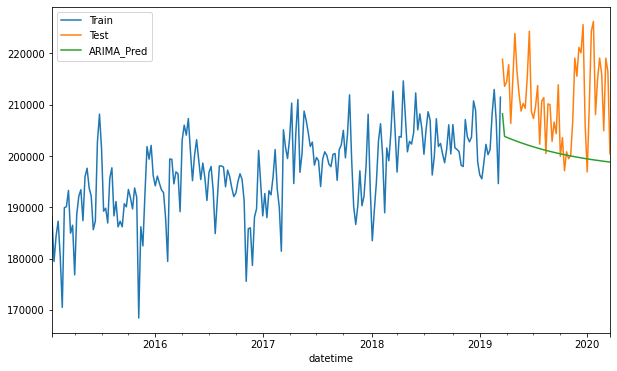

In [16]:
df_train.plot(legend = True,label = 'Train', figsize=(10,6))
df_test.plot(legend = True,label = 'Test')
pred.plot(legend = True,label = 'ARIMA_Pred')

# Auto ARIMA/SARIMA

## Train Model 

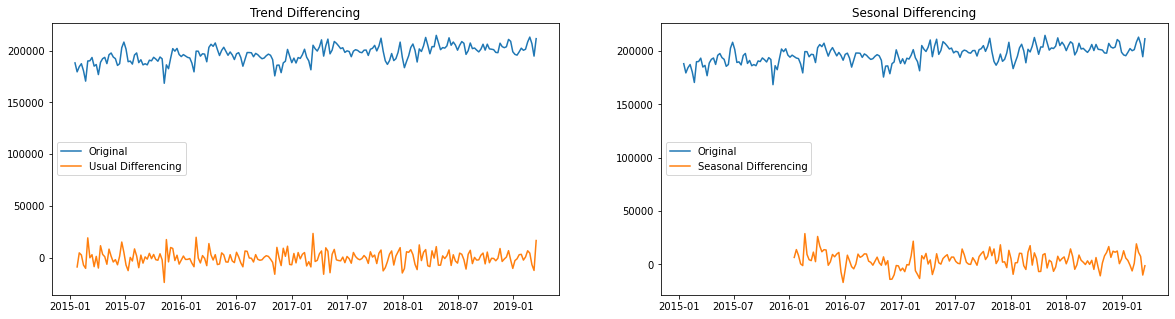

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
axes[0].plot(df_train, label= 'Original')
axes[0].plot(df_train.diff(1), label= 'Usual Differencing')             
axes[0].set_title('Trend Differencing')
axes[0].legend(loc='center left', fontsize=10)
axes[1].plot(df_train, label= 'Original')
axes[1].plot(df_train.diff(52), label= 'Seasonal Differencing')             
axes[1].set_title('Sesonal Differencing')
axes[1].legend(loc='center left', fontsize=10)
plt.show()

**There is no strong evidence that this series has seasonality**

In [18]:
arima= auto_arima(df_train,trace=True, error_action='ignore', test = 'adf',
                         start_p=1,start_q=1,max_p=10,max_q=10,m=1, D=0,      #D is the seasonal difference m is time step 
                   suppress_warnings=True,stepwise=True,seasonal=False)
arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4439.276, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5935.911, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5780.440, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4430.534, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4421.927, Time=0.69 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4446.972, Time=0.51 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.47 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=4424.894, Time=0.67 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0]          
Total fit time: 5.677

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -2205.964
Date:                Sun, 23 Apr 2023   AIC                           4421.927
Time:                        08:08:20   BIC                           4438.850
Sample:                    01-18-2015   HQIC                          4428.763
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3487      0.088     15.339      0.000       1.176       1.521
ar.L2         -0.5344      0.122     -4.384      0.000      -0.773      -0.296
ar.L3          0.1856      0.091      2.048      0.041       0.008       0.363
ma.L1         -0.8011      0.073    -10.922      0.000      -0.945      -0.657
sigma2      3.963e+07   6.25e-10   6.34e+16      0.000    3.96e+07    3.96e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 6.63
Prob(Q):                              0.77   Prob(JB):                         0.04
Heteroskedasticity (H):               0.71   Skew:                            -0.11
Prob(H) (two-sided):                  0.14   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.03e+33. Standard errors may be unstable.
"""

## Model Evaluation

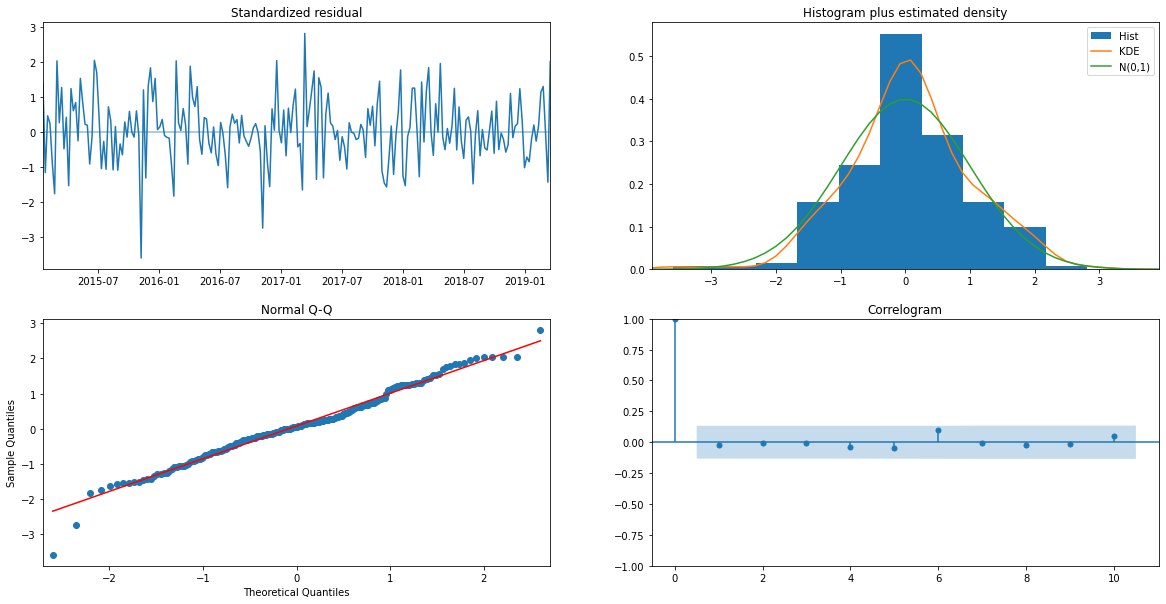

In [19]:
arima.plot_diagnostics(figsize=(20,10))
plt.show()

In [20]:
print("The Root Mean Squared Error is: "+ str(np.sqrt(mean_squared_error(df_test,pred))))

The Root Mean Squared Error is: 12745.584882387127


## Predict test dataset

<AxesSubplot:xlabel='datetime'>

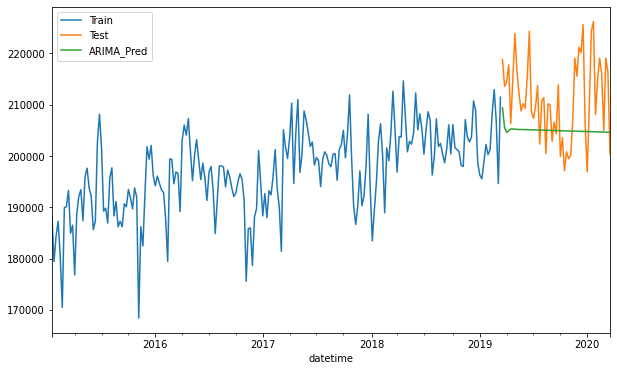

In [21]:
pred = arima.predict(n_periods = len(df_test) ) # set number of periods
df_train.plot(legend = True,label = 'Train', figsize=(10,6))
df_test.plot(legend = True,label = 'Test')
pred.plot(legend = True,label = 'ARIMA_Pred')

**This is a good improvment compare to the previous model**

# Auto ARIMA with Exogenous variables

In [22]:
df_exo = df_all.resample('W').sum().iloc[:,1:]        # Adding exogenous variable into our ARIMA model 
exo_train = df_exo[2:220]
exo_test = df_exo[220:273]

## Include only those exogenous variables that are significant

In [23]:
arimax= auto_arima(df_train,trace=True, X = exo_train[['T2M_toc','TQL_toc','QV2M_san','QV2M_dav','holiday']] 
                   , error_action='ignore', test = 'adf', approximation=False
                   , start_p=0,start_q=0,max_p=10,max_q=10,m=1, D=0,      # D is the seasonal difference m is time step 
                   suppress_warnings=True,stepwise=True,seasonal=False)
arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5464.301, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4282.008, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4389.045, Time=0.33 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4269.989, Time=0.30 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4261.630, Time=1.14 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4258.813, Time=0.82 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4255.799, Time=1.12 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=4257.615, Time=1.71 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=4252.408, Time=1.79 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4250.715, Time=1.46 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4249.808, Time=1.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4247.835, Time=0.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4253.838, Time=0.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4248.960, Time=1.28 sec
 ARIMA(1,0,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -2114.776
Date:                Sun, 23 Apr 2023   AIC                           4247.552
Time:                        08:08:39   BIC                           4278.013
Sample:                    01-18-2015   HQIC                          4259.856
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M_toc       43.4804      2.212     19.653      0.000      39.144      47.817
TQL_toc     -337.0749     63.729     -5.289      0.000    -461.982    -212.168
QV2M_san    4.081e+04   5842.900      6.985      0.000    2.94e+04    5.23e+04
QV2M_dav   -4.255e+04   7221.497     -5.892      0.000   -5.67e+04   -2.84e+04
holiday     -152.5740     11.533    -13.229      0.000    -175.179    -129.969
ar.L1          0.9939      0.011     89.353      0.000       0.972       1.016
ma.L1         -0.5359      0.075     -7.138      0.000      -0.683      -0.389
ma.L2         -0.2179      0.071     -3.048      0.002      -0.358      -0.078
sigma2      1.564e+07     16.978   9.21e+05      0.000    1.56e+07    1.56e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.96   Prob(JB):                         0.43
Heteroskedasticity (H):               1.27   Skew:                             0.14
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.37e+21. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='datetime'>

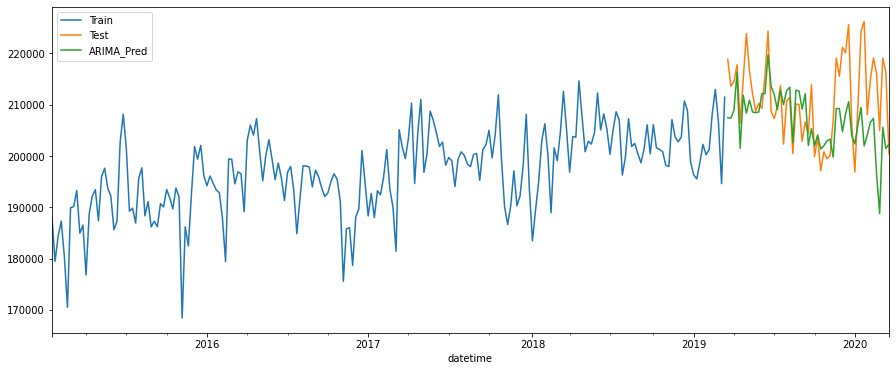

In [24]:
pred_x = arimax.predict(n_periods = len(df_test),X = exo_test[['T2M_toc','TQL_toc','QV2M_san','QV2M_dav','holiday']] ) # set number of periods
df_train.plot(legend = True,label = 'Train', figsize=(15,6)) 
df_test.plot(legend = True,label = 'Test')
pred_x.plot(legend = True,label = 'ARIMA_Pred')

In [25]:
print("The Root Mean Squared Error is: "+ str(np.sqrt(mean_squared_error(df_test,pred_x))))

The Root Mean Squared Error is: 8515.11277914274


## Include all exogenous variables available

In [26]:
arimax= auto_arima(df_train,trace=True, X = exo_train
                   , error_action='ignore', test = 'adf', approximation=False
                   , start_p=0,start_q=0,max_p=10,max_q=10,m=1, D=0,      # D is the seasonal difference m is time step 
                   suppress_warnings=True,stepwise=True,seasonal=False)
arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5457.872, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4296.775, Time=0.75 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4410.307, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4275.531, Time=0.80 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4273.196, Time=0.95 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=2.51 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4257.594, Time=2.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4254.509, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4258.165, Time=0.77 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=1.87 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4255.267, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4258.428, Time=0.97 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 15.384 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  218
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -2108.254
Date:                Sun, 23 Apr 2023   AIC                           4254.509
Time:                        08:08:54   BIC                           4318.814
Sample:                    01-18-2015   HQIC                          4280.483
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T2M_toc       26.7297      9.225      2.898      0.004       8.649      44.810
QV2M_toc   -8494.2049   9264.339     -0.917      0.359   -2.67e+04    9663.565
TQL_toc     -443.1382    143.016     -3.099      0.002    -723.444    -162.833
W2M_toc        1.1478      1.403      0.818      0.413      -1.602       3.897
T2M_san       -2.3755      9.197     -0.258      0.796     -20.402      15.651
QV2M_san     3.64e+04   1.16e+04      3.151      0.002    1.38e+04     5.9e+04
TQL_san     -170.5162    130.402     -1.308      0.191    -426.099      85.066
W2M_san        3.1371      2.852      1.100      0.271      -2.454       8.728
T2M_dav       18.0537     12.898      1.400      0.162      -7.225      43.332
QV2M_dav   -2.738e+04   1.14e+04     -2.399      0.016   -4.98e+04   -5011.328
TQL_dav      334.4800     96.414      3.469      0.001     145.512     523.448
W2M_dav       -6.7833      5.415     -1.253      0.210     -17.397       3.830
Holiday_ID     1.1729      2.813      0.417      0.677      -4.340       6.686
holiday     -171.1990     34.090     -5.022      0.000    -238.015    -104.383
school         7.7993      6.887      1.132      0.257      -5.700      21.298
ar.L1          1.2582      0.117     10.775      0.000       1.029       1.487
ar.L2         -0.2593      0.116     -2.244      0.025      -0.486      -0.033
ma.L1         -0.8902      0.063    -14.123      0.000      -1.014      -0.767
sigma2      1.798e+07     23.265   7.73e+05      0.000     1.8e+07     1.8e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                 0.83
Prob(Q):                              0.51   Prob(JB):                         0.66
Heteroskedasticity (H):               1.37   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.66e+21. Standard errors may be unstable.
"""

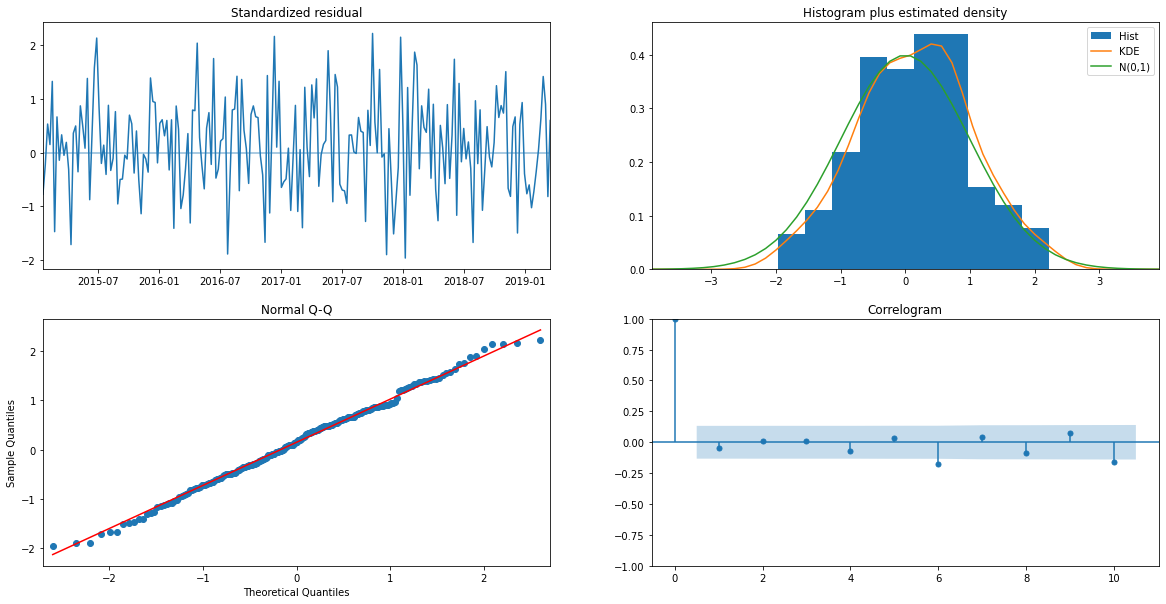

In [27]:
arimax.plot_diagnostics(figsize=(20,10))
plt.show()

**In Normal Q-Q plot. most dots fall perfectly in line with the red line compare to previous results **

<AxesSubplot:xlabel='datetime'>

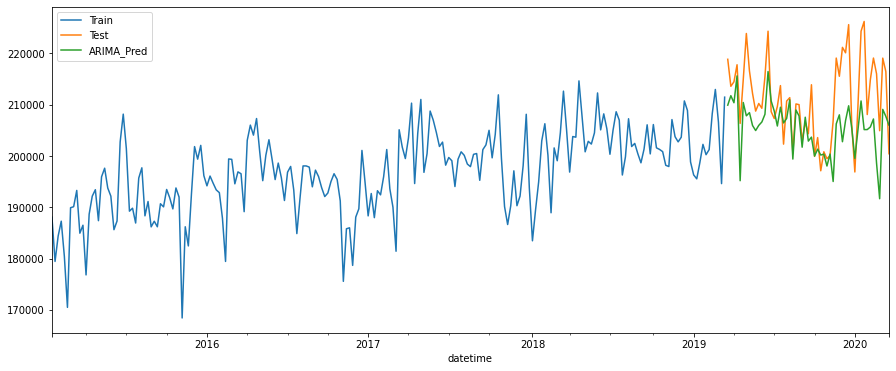

In [28]:
pred_x = arimax.predict(n_periods = len(df_test),X = exo_test) # set number of periods
df_train.plot(legend = True,label = 'Train', figsize=(15,6)) 
df_test.plot(legend = True,label = 'Test')
pred_x.plot(legend = True,label = 'ARIMA_Pred')

In [29]:
print("The Root Mean Squared Error is: "+ str(np.sqrt(mean_squared_error(df_test,pred_x))))

The Root Mean Squared Error is: 8318.698521093744


**This is the best model we have so far, we can improve our model by applying data preprocessing for exogenous variables.**